# Replication: Proportional Representation and Right-Wing Populism: Evidence from Electoral System Change in Europe

**Paper:** Becher M, Menéndez González I, Stegmueller D (2023). Proportional Representation and Right-Wing
Populism: Evidence from Electoral System Change in Europe. British Journal of Political Science 53, 261–268. https://
doi.org/10.1017/S0007123421000703

**Background Information:**

research question: Did the electoral system change from a first-past-the-post to a PR (proportional representation) system for the EP (European Parliament) in the UK (United Kingdom) lead to a rise in far-right populist (RWP) vote shares?

methods:
1. Synthetic Control Method
2. Difference-In-Differences Design
3. Robustness Tests

**Synthetic Control Method:**

The synthetic control method is used when we only have one treated unit and no counterfactual control group. It answers the assignment problem of how to estimate this missing counterfactual if one only has a single treated estimation, meaning it estimates the effect of an intervention on treatment when a randomized experiment is not feasible. Following this approach, the SCM constructs a synthetic control group (= counterfactual) by optimally weighting untreated units to resemble the treated unit before the intervention.

*Why suitable for this study?*

In this study, we only have one treated unit: the UK. In 1999, it passed an electoral reform adopting a proportional electoral system instead of the previous first-past-the-post electoral system for the European elections. This reform is the treatment. The authors argue that we could compare the UK to the EU8 countries (the eight countries that have participated in all prior election years and had stable proportional electoral systems), but these two units diverge greatly in their pre-treatment developments, violating the parallel trends assumption. This is why we cannot simply use the EU8 average as a control group and cannot perform a DiD experiment, as it would be largely biased due to violations of the identification assumption (common trends).    
Hence, the authors propose a SCM to create a synthetic UK that is used as the counterfactual / control group and estimated based on the EU8 countries.

Another reason is that the treatment was certainly not randomly assigned, meaning we usually cannot estimate causal effects. Though, by creating a synthetic control group, causal claims can be made and the effect of the electoral reform on right-wing populist (RWP) voting in the EU elections can be estimated.

*Key Identification Assumption*

Conditional Independence / Ignorability Assumption (stronger than parallel trends; identical instead of parallel trajectories)

In [1]:
# import relevant packages
import pandas as pd
import pyreadstat as prs
import numpy as np
from matplotlib import pyplot as plt

## for the SCM
from pysyncon import Dataprep, Synth
from pysyncon.utils import PlaceboTest

# Set random seed for reproducibility
np.random.seed(54321)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# load main data
filepath = 'Replication_Archive/CountryEPData.dta'
filepath_IP = 'Replication_Archive/CountryEPData_covIP.dta'

df_c = pd.read_stata(filepath)
df_IP, df_IP_meta = prs.read_dta(filepath_IP)

print(f'Country EP Data: {df_c.shape[0]} observations, {df_c.shape[1]} variables')
print(f'Country EP Data - IP: {df_IP_meta.number_rows} observations, {df_IP_meta.number_columns} variables')

# pre-processing main data

## merge datasets
df = df_c.merge(df_IP, on=['ccode', 'year', 'ep_election'], how='left')

df = df[~df['ccode'].isin([5,9,12])]                                        # excluded: Spain (5), Luxembourg (9), Portugal (12); France excluded later
df = df[df['ep_election'] != 2019]                                          # exclude 2019 election
df = df[df['year'].isin(df['ep_election'].unique())]                        # subset data to EP election years
df['opencIP'] = df['opencIP'] / 100                                         # adjust opencIP (from percentage)

# keep only relevant columns (IP = interpolated; treated for missing values)
## ch_imp_fns still has missing values / exclude in favor of ch_imp_aec?
keep_cols = ['ccode', 'country', 'ep_election', 'rr_votes',
            'unempIP', 'opencIP', 'pop', 'S_uegenIP', 'E_eubadIP', 'RAIIP', 'E_NatDem_satisfiedIP', 'enep_ep', 'ch_imp_aec', 'ch_imp_fns', 
            'rightgovIP', 'eu_pos_meanIP', 'migr_inflIP', 'effpar_eleIP']
df = df[keep_cols]

print(f'Merged Dataframe: {df.shape[0]} observations, {df.shape[1]} variables')
print(f'Countries: {df['country'].nunique()}')
print(f'Time periods: {sorted(df['ep_election'].unique())}')

df.head()

Country EP Data: 492 observations, 20 variables
Country EP Data - IP: 360 observations, 11 variables
Merged Dataframe: 72 observations, 18 variables
Countries: 9
Time periods: [np.float64(1979.0), np.float64(1984.0), np.float64(1989.0), np.float64(1994.0), np.float64(1999.0), np.float64(2004.0), np.float64(2009.0), np.float64(2014.0)]


,ccode,country,ep_election,rr_votes,unempIP,opencIP,pop,S_uegenIP,E_eubadIP,RAIIP,E_NatDem_satisfiedIP,enep_ep,ch_imp_aec,ch_imp_fns,rightgovIP,eu_pos_meanIP,migr_inflIP,effpar_eleIP
5,1,Belgium,1979.0,0.00,7.0,1.008315,9848.381836,13.4,0.026752,26.035097,0.457645,6.855447,0.117128,0.127384,0.0,6.427861,NaN,7.546885
10,1,Belgium,1984.0,1.28,10.8,1.272862,9855.372070,13.9,0.055122,28.955644,0.469118,8.333200,0.194520,0.196926,1.0,6.423333,47862.0,9.040284
15,1,Belgium,1989.0,4.09,7.4,1.240117,9937.697266,13.7,0.041469,36.184745,0.609894,8.438431,0.236003,0.257358,0.0,6.450000,49680.8,8.167466
20,1,Belgium,1994.0,10.73,9.8,1.123887,10115.599609,13.6,0.084512,36.184745,0.560000,10.419480,0.867241,0.956367,0.0,6.540000,65158.5,9.842326
25,1,Belgium,1999.0,10.91,8.4,1.239970,10226.419922,13.3,0.069660,32.093154,0.525166,10.625746,1.888104,1.865758,0.0,6.722222,87718.0,10.288595


In [3]:
# loading and pre-processing Westminster data
filepath_wm = '/home/dino/Documents/Studium/Master-SocialDataScience_Mannheim/01_HWS2025-26/SamplingAndData/Exam/Replication_Archive/westminster.csv'
df_wm = pd.read_csv(filepath_wm)
df_wm = df_wm[df_wm['year'] <= 2015]

print(f'Westminster Data: {df_wm.shape[0]} observations, {df_wm.shape[1]} variables')
print(f'Time periods: {sorted(df_wm['year'])}')

df_wm.head()

Westminster Data: 9 observations, 6 variables
Time periods: [1979, 1983, 1987, 1992, 1997, 2001, 2005, 2010, 2015]


,year,antifed_vot,ukip_vote,bnp_vote,refparty_vote,westminster_vote
0,1979,0.0,0.0,0.0,0.0,0.0
1,1983,0.0,0.0,0.0,0.0,0.0
2,1987,0.0,0.0,0.1,0.0,0.1
3,1992,0.1,0.0,0.1,0.0,0.2
4,1997,0.0,0.3,0.1,2.6,0.4


# 1. Replication (p. 263-266)

## 1.1 Development of RWP Vote Shares and DiD Design

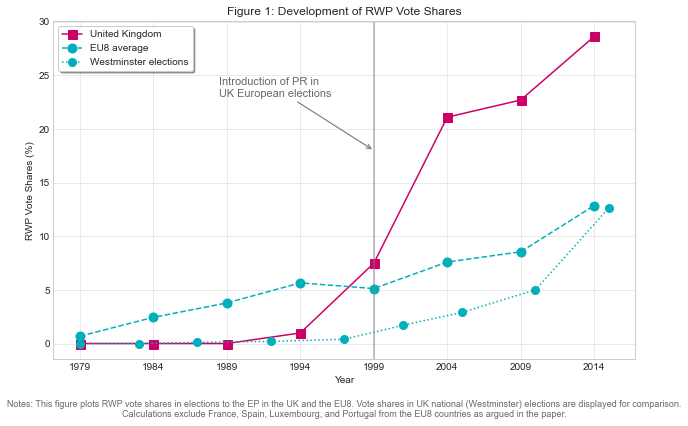

In [4]:
# preparing the data
all_years = sorted(df['ep_election'].unique())
uk_avg = df.loc[df['ccode'] == 11].groupby('ep_election')['rr_votes'].mean()
eu8_avg = df.loc[df['ccode'] != 11].groupby('ep_election')['rr_votes'].mean()

# plotting
plt.figure(figsize=(10,6))

plt.plot(all_years, uk_avg, 's-', color='#CC0066', markersize=9, label='United Kingdom')
plt.plot(all_years, eu8_avg, 'o--', color='#00AFBB', markersize=9, label='EU8 average')
plt.plot(df_wm['year'], df_wm['westminster_vote'], 'o:', color='#00AFBB', markersize=8, label='Westminster elections')

plt.axvline(1999, color='gray', alpha=0.6)

plt.xlabel('Year', fontsize=10)
plt.ylabel('RWP Vote Shares (%)', fontsize=10)
plt.xticks(all_years)
plt.title('Figure 1: Development of RWP Vote Shares', size=12)

plt.annotate('Introduction of PR in\nUK European elections', xy=(1999, 18), xytext=(1988.5, 23), arrowprops=dict(arrowstyle='->', color='gray', lw=1.2),
             fontsize=11, color='dimgray')

plt.text(0.5, -0.12, 'Notes: This figure plots RWP vote shares in elections to the EP in the UK and the EU8. Vote shares in UK national (Westminster) elections are displayed for comparison.\nCalculations exclude France, Spain, Luxembourg, and Portugal from the EU8 countries as argued in the paper.',
         fontsize=9, color='dimgray', ha='center', va='top', transform=plt.gca().transAxes)

plt.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True)

plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('Figure1_RWP-Vote-Shares.pdf')
plt.show()

**Interpretation:**

Figure 1 "plots the evolution of the combined vote share of RWP parties in the UK in EP elections between 1979 and 2014 compared to an unweighted average of EU8 countries and UK national (that is, Westminster) elections" (p. 263).

Here we can see the trajectories of the UK, the EU8 average and the national (Westminster) elections. This is also an evaluation of whether one of the two comparison cases could potentially be used as a counterfactual in a difference-in-differences (DiD) design.

First, for the UK, we can see that there was a sharp rise in right-wing populist vote shares starting from 1999 and a very small raise in 1994.  This steep rise of RWP vote shares in the UK Eruopean elections after the reform stands in contrast to the evolution in the EU8 countries as well as in the national elections.

The EU8 RWP vote shares in European parliament (EP) elecitons already increase noticably before 1999. This suggests that a simple, unweighted EU8 average makes for an inadequte counterfactual comparison case.

In contrast, the national (Westminster) elections show very similar pre-reform levels of RWP vote shares to the EP elections and the RWP levels diverge sharply after the electoral reform. This might seem appealing for a control group, especially as using the national elections would also keep constant country and time-varying factors shaping populist demand due to the same country baseline (UK). However, this within-country comparison has very strong limitations as it does not account for the strategic interdependence of the two electoral arenas. In short: spillover effects threaten the identification assumptions of a DiD approach. This can easily be argued: The success of RWP parties in Europe may spill over into national elections and vice versa. While the effect would be more conservative if higher vote shares in EP elections lead to higher vote shares in national elections (and thus, could be used), the effect can else be negative and the other way around. This means, the effect can not be isolated and would potentially be biased. Hence, the national elections are also not a suitable control group for this case.

This is why the authors use a synthetic control approach to create a synthetic UK as the counterfactual (control group).

**DiD Estimand for Comparison:**

Nonetheless, the authors compute DiD estimates for comparison. While they use several different models (p. 266), I only computed a simple, two-group and two-period DiD estimand for comparison here. This accounts for time-invariant unobserved differences between the UK and other countries and common shocks (i.e. treaty changes and factors that increase the demand or supply or populism).

In [5]:
# UK vs. EU8 average
all_years = sorted(df['ep_election'].unique())
uk_avg = df.loc[df['ccode'] == 11].groupby('ep_election')['rr_votes'].mean()
eu8_avg = df.loc[df['ccode'] != 11].groupby('ep_election')['rr_votes'].mean()

pre = [1979, 1984, 1989, 1994]
post = [1999, 2004, 2009, 2014]

uk_change = uk_avg.loc[post].mean() - uk_avg.loc[pre].mean()
print(f'DiM Estimate (ATE) UK: {round(uk_change, 4)} (provided purely for comparison)')
eu8_change = eu8_avg.loc[post].mean() - eu8_avg.loc[pre].mean()

did_att = uk_change - eu8_change
print(f'DiD Estimate (ATT) UK vs. EU8: {round(did_att, 4)}')
print('\nComparison to the Paper: DiD estimate = 14.34 (same!)')

DiM Estimate (ATE) UK: 19.7319 (provided purely for comparison)
DiD Estimate (ATT) UK vs. EU8: 14.3369

Comparison to the Paper: DiD estimate = 14.34 (same!)


## 1.2 Synthetic Control Method

### 1.2.1 Main Model

In [6]:
# exclude France for this part
df_synth = df[df['ccode'] != 6].copy()

# subset data to relevant variables
keep_synth = ['ccode','country','ep_election', 'rr_votes',
             'unempIP', 'opencIP', 'S_uegenIP', 'E_eubadIP', 'E_NatDem_satisfiedIP', 'ch_imp_fns', 'rightgovIP', 'eu_pos_meanIP', 'migr_inflIP']
df_synth = df_synth[keep_synth]

In [7]:
# build dataprep object

## preparation of variables
treatment_time_plac = 1999
pre_years = [1979, 1984, 1989, 1994]
post_years = [1999, 2004, 2009, 2014]
all_years = pre_years + post_years

treated_unit = 'United Kingdom'
donor_units = ['Belgium', 'Denmark', 'Greece', 'Germany', 'Ireland', 'Italy', 'Netherlands']

predictors = ['unempIP', 'opencIP', 'S_uegenIP', 'E_eubadIP', 'E_NatDem_satisfiedIP', 'ch_imp_fns', 'rightgovIP', 'eu_pos_meanIP', 'migr_inflIP']
special_predictors = [
    # migr_inflIP only from 1984–1994 (same original years)
    ("migr_inflIP", [1984, 1989, 1994],'mean'),
    # lagged outcome in 1994
    ("rr_votes", [1994], 'mean')
]

## dataprep object
dataprep = Dataprep(
    foo=df_synth,
    predictors=predictors,
    predictors_op='mean',
    time_predictors_prior=pre_years,
    special_predictors=special_predictors,
    dependent='rr_votes',
    unit_variable='country',
    time_variable='ep_election',
    treatment_identifier=treated_unit,
    controls_identifier=donor_units,
    time_optimize_ssr=pre_years
)

print(dataprep)

Dataprep
Treated unit: United Kingdom
Dependent variable: rr_votes
Control units: Belgium, Denmark, Greece, Germany, Ireland, Italy, Netherlands
Time range in data: 1979.0 - 2014.0
Time range for loss minimization: [1979, 1984, 1989, 1994]
Time range for predictors: [1979, 1984, 1989, 1994]
Predictors: unempIP, opencIP, S_uegenIP, E_eubadIP, E_NatDem_satisfiedIP, ch_imp_fns, rightgovIP, eu_pos_meanIP, migr_inflIP
Special predictors:
    `migr_inflIP` over `[1984, 1989, 1994]` using `mean`
    `rr_votes` over `[1994]` using `mean`



In [8]:
# fit synthetic control (Nelder-Mead/Powell (even one covariate zeroed) weighting optimization) / L-BFGS-B / COBYLA (! countries from paper + additional ones)
synth = Synth()
synth.fit(dataprep=dataprep, optim_method='COBYLA', optim_initial='equal')            # maybe try different method: 'Nelder-Mead'

In [9]:
# country weights
weights = synth.weights()
print(f'Country Weights:\n{weights}')

print(f'\nSorted Weights:\n{weights[weights > 0.01].sort_values(ascending=False)}')

print('\nComparing to the Paper: Netherlands (0.753), Ireland (0.229), Belgium (0.018)')

Country Weights:
Belgium        0.053
Denmark        0.201
Greece         0.298
Germany        0.000
Ireland        0.212
Italy          0.000
Netherlands    0.236
Name: weights, dtype: float64

Sorted Weights:
Greece         0.298
Netherlands    0.236
Ireland        0.212
Denmark        0.201
Belgium        0.053
Name: weights, dtype: float64

Comparing to the Paper: Netherlands (0.753), Ireland (0.229), Belgium (0.018)


In [10]:
# predictor weights / comparison
print('Predictor Weights and Balance:')
synth.summary()

Predictor Weights and Balance:


,V,treated,synthetic,sample mean
unempIP,0.255,7.975,8.139,8.111
opencIP,0.012,0.512,0.796,0.747
S_uegenIP,0.203,9.450,9.034,9.271
E_eubadIP,0.011,0.284,0.124,0.098
E_NatDem_satisfiedIP,0.017,0.546,0.586,0.551
ch_imp_fns,0.228,0.549,0.610,0.724
rightgovIP,0.014,0.750,0.412,0.393
eu_pos_meanIP,0.021,5.107,5.814,6.047
migr_inflIP,0.016,220066.667,47324.863,180365.283
special.1.migr_inflIP,0.014,220066.667,47324.863,180365.283


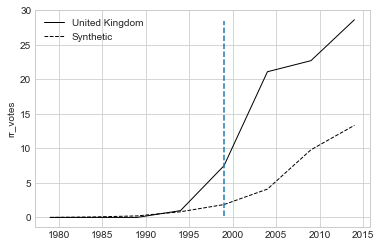

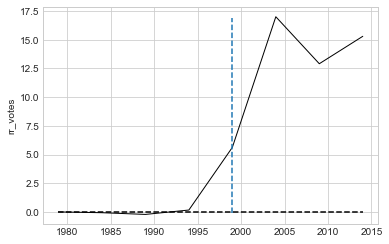

In [11]:
# basic plots (general vs. pointwise)
synth.path_plot(time_period=all_years, treatment_time=1999)

synth.gaps_plot(time_period=all_years, treatment_time=1999)

In [12]:
# ATT (post-treatment) and Error Terms
print('MSPE (Mean Squared Approximation Error) Post Treatment:', round(synth.mspe(post_years), 4))
scm_att = synth.att(time_period=post_years)
scm_att = scm_att['att']
scm_att_se = synth.att(time_period=post_years)['se']
print(f'SCM ATT: {round(scm_att, 4)} (se: {round(scm_att_se, 4)})')

print('\nComparison to Paper: ATT = 13.5 percentage points')

MSPE (Mean Squared Approximation Error) Post Treatment: 0.0197
SCM ATT: 12.7039 (se: 2.506)

Comparison to Paper: ATT = 13.5 percentage points


**Interpretation:**

The **first plot** (equals left panel of Figure 2) shows the combined vote share of RWP parties in the UK in European elections btween 1979 and 2014 compared to the synthetic UK. We can see that the growth of RWP votes in the UK sharply diverges from the synthetic UK with the introduction of the proportional representation (PR) electoral system in 1999. The development of the gap between the two units is more intuitively visible in the **second plot** (equals parts of right panel of Figure 2) that estimates the impact of the electoral reform on the electoral performance of the populist right in the UK: With the introduction of PR, a gap of 5.6 percentage points emerges between the UK and its synthetic counterpart, followed by an even larger gap in the 2004 election (17 percentage points). After that the gap remains large but first slightly decreases in 2009 (12.9 percentage points), then increases again in 2014 (15.3 percentage points).

The average treatment effect on the treated (**ATT**), meaning the average difference in RWP vote shares over the post-reform EP elections between the UK and the synthetic UK, amounts to 12.7039 percentage points. This estimand is slightly lower than that of the original paper (13.5 %pts), though this difference is explainable by the different mathematical operations for the nested optimization problems (see more below).

The synthetic control is comprised of **five donor units**, namely Greece (0.298), the Netherlands (0.236), Ireland (0.212), Denmark (0.201) and Belgium (0.053). In this point, my replication diverges slightly from the paper that only distributes weights to the Netherlands (0.753), Ireland (0.229), Belgium (0.018). This difference is most likely due to slight differences in the mathematical operizations for the nested optimization problem (weighting).    
Still, the argumentations of the authors should apply to the w-weight distribution here: the donor set is comprised of some countries with open economies with strong trade and historical links to the UK of which some have high effective electoral thresholds (i.e. Ireland, Belgium) and some have lower thresholds (i.e. Netherlands). As a set, these donors constitute the synthetic control because the sum of their weighted pre-treamtnet trajectories and predictor profiles closely match the UK (treated unit).

Looking at the covariate weights (**v-weights**), we can see that all covariates contribute to some degree to the synthetic control in their predictive importance, though multiple variables are very close to 0. Especially important covariates are unemployment rates (`unempIP`), generosity of unemployment insurance benefits (`S_uegenIP`), chinese imports (`ch_imp_fns`) and the lagged outcome variable, meaning RWP vote shares in 1994 (`rr_votes`).    
Again, in this point, my replication diverges from the paper, as the authors report v-weights that contribute minimal importance to chinese imports and the rest to the lagged outcome. This is also likely due to differences in the minimization calculations.

To check whether the pre-treatment fit is acceptable for credible inference, I calculated a **balance table** of the covariates over the pre-treatment period. Here, as well as in the figures above plotting the trajectories and the gaps between the real and synthetic UK, we can see that the synthetic control group very closely resembles the real UK. All covariate means are very similar to almost identical, leading to (almost) identical pre-treatment trajectories. Hence, the identification assumption (conditional independence / ignorability &rarr; implies parallel trends, but stronger) is satisfied, the covariates are balanced and the pre-treatment fit is very acceptable for credible inference.

One thing possible challenging the SCM assumptions is the general upward trend in RWP vote shares across Europe. Though, the authors account for this by including a **lagged outcome** variable of RWP vote shares in 1994. By doing this, they control for potential influences of the general upward trend in RWP vote shares on the upward trend in the UK - thereby making their estimate more conservative and preserving the validity of the SCM approach.

            Model   Estimand
0          UK DiM  19.731875
1  UK vs. EU8 DiD  14.336875
2         SCM ATT  12.703872


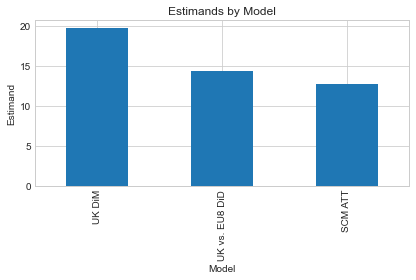

In [13]:
# comparison of DiM, DiD and SCM
estimand_comparison = {
    'Model' : ['UK DiM', 'UK vs. EU8 DiD', 'SCM ATT'],
    'Estimand' : [uk_change, did_att, scm_att]
}

estimand_comp_df = pd.DataFrame(estimand_comparison)
print(estimand_comp_df.head())

# bar plot
ax = estimand_comp_df.plot(
    x='Model',
    y='Estimand',
    kind='bar',
    legend=False
)

ax.set_xlabel('Model')
ax.set_ylabel('Estimand')
ax.set_title('Estimands by Model')
plt.tight_layout()
plt.show()

**Interpretation:**
The SCM ATT is the lowest estimand. This makes sense since the approach is the only one where the identification assumptions hold and should therefore be the least biased estimate.

### 1.2.2 In-Space Placebo Test

In [14]:
# in-space placebo
placebo_test = PlaceboTest()
placebo_test.fit(
    dataprep=dataprep,
    scm=synth,
    scm_options={'optim_method': 'COBYLA', 'optim_initial': 'equal'},
)

(1/7) Completed placebo test for Italy.
(2/7) Completed placebo test for Denmark.
(3/7) Completed placebo test for Germany.
(4/7) Completed placebo test for Netherlands.
(5/7) Completed placebo test for Ireland.
(6/7) Completed placebo test for Greece.
(7/7) Completed placebo test for Belgium.
Calculating treated unit gaps.
Done.


In [15]:
print(f'Placebo Test P-Value: {placebo_test.pvalue(treatment_time=1999)}')

Placebo Test P-Value: 0.125


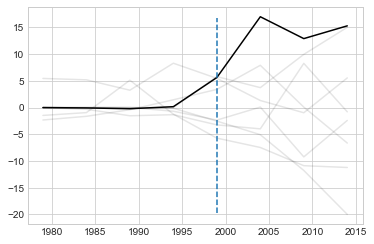

In [16]:
placebo_test.gaps_plot(time_period=all_years, treatment_time=1999)

**Interpretation:**
The in-space placebo test is created by applying the synthetic control method (SCM) to each of the potential donor countries, assuming that 1999 is the placebo electoral reform. Hence, this in-space placebo test is a permutation test based on Fisher's sharp null hypothesis. This states that the pre- and post-treatment trajectories are the same for every observation, hence, there is no treatment effect. It is estimated by permuting the treatment across all possible units, thereby computing a null distribution that is then compared to the main estimand (here: SCM ATT = 12.7039). The p-value estimates the probability of finding an effect, in magnitude, as least as extreme as the observed test statistic, under the null hypothesis. 

In the paper, "no country shows an estimated increase in RWP votes as large as, or larger, than, the UK in any of the post-reform elections" (p. 265). However, in my replication one country does show a larger estimand (Ireland; ATT = -14.7893). This results in a one-sided placebo test p-value of 0.125. Hence, the effect is statistically non-significant and we cannot reject the null hypothesis.

### 1.2.3 Alternative Coding Version for Figure 2 (styled as in the paper)

This chapter still uses the pysyncon module but adds some self-written helper functions to work around the restrictions with creating plots in the module.

Description of Figure 2 in the paper: "Panel ‘a’ plots RWP vote shares in EP elections in the UK (magenta line), which replaced its first-past-the-post system with a PR electoral system in 1999, compared to three control cases: ‘synthetic’ UK, constructed via generalized synthetic control estimation (green line), the EU8 average and Westminster elections (dashed lines). Panel ‘b’ plots the difference in RWP vote shares (percentage points) between treated and synthetic control units. Grey lines plot gaps for placebo-treated units." (p. 264)

In [17]:
df_wide = df_synth.pivot_table(index='ep_election', columns='country', values='rr_votes', aggfunc='first')
df_wide.head()

country,Belgium,Denmark,Germany,Greece,Ireland,Italy,Netherlands,United Kingdom
ep_election,,,,,,,,
1979.0,0.00,0.0,0.0,0.0,0.0,5.45,0.00,0.0000
1984.0,1.28,0.0,0.8,0.0,0.0,6.47,0.00,0.0000
1989.0,4.09,0.0,7.1,0.0,0.0,7.34,0.00,0.0000
1994.0,10.73,0.0,3.9,0.0,0.0,19.03,1.05,0.9825
1999.0,10.91,5.8,1.7,0.0,0.0,16.38,0.50,7.4800


In [18]:
# helper functions for extracting data and plotting
def get_synth_outcome(synth_obj, all_years):
    '''Get synthetic outcome for each year.'''
    w = synth_obj.weights()
    synth_values = []
    for year in all_years:
        weighted_sum = 0
        for country, weight in w.items():
            if weight > 0 and country in df_wide.columns:
                val = df_wide.loc[year, country] if year in df_wide.index else 0
                weighted_sum += weight * val
        synth_values.append(weighted_sum)
    return synth_values

def get_treated_outcome(years):
    '''Get UK outcome for each year.'''
    return [df_wide.loc[year, treated_unit] for year in years]

def get_gaps(synth_obj, years):
    '''Get gap (treated - synthetic) for each year.'''
    treated = get_treated_outcome(years)
    synthetic = get_synth_outcome(synth_obj, years)
    return [t - s for t, s in zip(treated, synthetic)]

In [19]:
# calculate main results
y_treat = get_treated_outcome(all_years)
y_synth = get_synth_outcome(synth, all_years)
gaps = get_gaps(synth, all_years)

df_results = pd.DataFrame({
    'Year': all_years,
    'UK': y_treat,
    'Synth': y_synth,
    'Gap': gaps,
    'Period': ['pre' if year < 1999 else 'post' for year in all_years]
})

# Display nicely formatted
print('ATT per Year:')
df_results.round(4).head(10)

ATT per Year:


,Year,UK,Synth,Gap,Period
0,1979,0.0000,0.0000,0.0000,pre
1,1984,0.0000,0.0678,-0.0678,pre
2,1989,0.0000,0.2168,-0.2168,pre
3,1994,0.9825,0.8165,0.1660,pre
4,1999,7.4800,1.8620,5.6180,post
5,2004,21.1000,4.1042,16.9958,post
6,2009,22.7000,9.7994,12.9006,post
7,2014,28.6300,13.3468,15.2832,post


In [20]:
placebo_gaps = {}

for placebo_unit in donor_units:
    print(f'{placebo_unit}...')
    
    placebo_donors = [d for d in donor_units if d != placebo_unit]
    placebo_donors.append(treated_unit)
    
    # create dataprep for placebo
    dataprep_placebo = Dataprep(
        foo=df_synth,
        predictors=predictors,
        predictors_op='mean',
        time_predictors_prior=pre_years,
        special_predictors=special_predictors,
        dependent='rr_votes',
        unit_variable='country',
        time_variable='ep_election',
        treatment_identifier=placebo_unit,
        controls_identifier=placebo_donors,
        time_optimize_ssr=pre_years,
    )
    
    # fit sc
    synth_placebo = Synth()
    synth_placebo.fit(dataprep=dataprep_placebo, optim_method='COBYLA', optim_initial='equal')
    
    # get gaps manually
    w_placebo = synth_placebo.weights()

    Y_placebo_treat = [df_wide.loc[year, placebo_unit] for year in all_years]
    Y_placebo_synth = []
    for year in all_years:
        weighted_sum = 0
        for country, weight in w_placebo.items():
            if weight > 0 and country in df_wide.columns:
                weighted_sum += weight * df_wide.loc[year, country]
        Y_placebo_synth.append(weighted_sum)
    
    placebo_gaps[placebo_unit] = [t - s for t, s in zip(Y_placebo_treat, Y_placebo_synth)]
    
    att_p = synth_placebo.att(time_period=post_years)
    print(f' ATT = {att_p['att']:.4f}')

Belgium...
 ATT = 1.1836
Denmark...
 ATT = 3.2333
Greece...
 ATT = -4.6068
Germany...
 ATT = -8.4923
Ireland...
 ATT = -14.7893
Italy...
 ATT = 2.8425
Netherlands...
 ATT = -5.8808


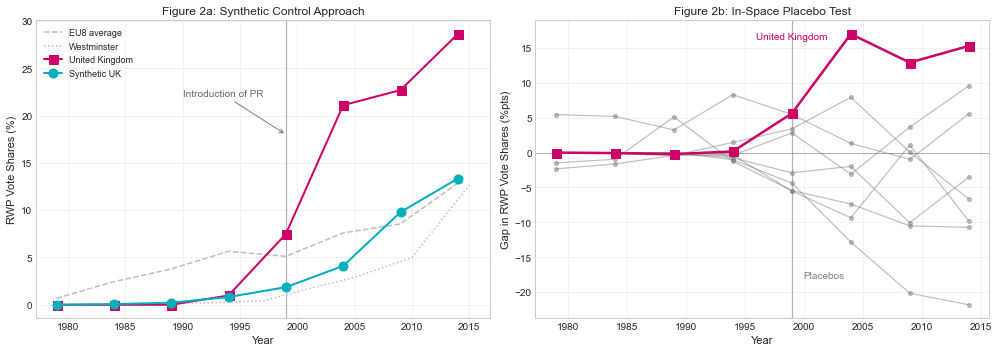

In [21]:
# EU average for comparison
eu8_avg = df.loc[df['ccode'] != 11].groupby('ep_election')['rr_votes'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Levels
ax1 = axes[0]
ax1.grid(True, alpha=0.3, zorder=0)
ax1.axvline(1999, color='gray', lw=1.2, alpha=0.6, zorder=1)

ax1.plot(all_years, eu8_avg.loc[all_years], '--', color='#BEBEBE', lw=1.5, label='EU8 average', zorder=2)
ax1.plot(df_wm['year'], df_wm['westminster_vote'], ':', color='#BEBEBE', lw=1.5, label='Westminster', zorder=2)
ax1.plot(all_years, y_treat, 's-', color='#CC0066', lw=2, ms=9, label='United Kingdom', zorder=3)
ax1.plot(all_years, y_synth, 'o-', color='#00AFBB', lw=2, ms=9, label='Synthetic UK', zorder=3)

ax1.annotate('Introduction of PR', xy=(1999, 18), xytext=(1990, 22),
            arrowprops=dict(arrowstyle='->', color='gray'), fontsize=10, color='dimgray')

ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('RWP Vote Shares (%)', fontsize=11)
ax1.legend(loc='upper left', fontsize=9)
ax1.set_title('Figure 2a: Synthetic Control Approach', fontsize=12)

# Panel B: Gaps
ax2 = axes[1]
ax2.grid(True, alpha=0.3, zorder=0)
ax2.axvline(1999, color='gray', lw=1.2, alpha=0.6, zorder=1)
ax2.axhline(0, color='gray', lw=1.0, alpha=0.6, zorder=1)

# Plot placebo gaps (gray)
for unit, p_gaps in placebo_gaps.items():
    ax2.plot(all_years, p_gaps, 'o-', color='gray', lw=1.2, ms=4, alpha=0.5, zorder=2)

# Plot UK gap (pink/magenta)
ax2.plot(all_years, gaps, 's-', color='#CC0066', lw=2.5, ms=9, zorder=3, label='United Kingdom')

ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Gap in RWP Vote Shares (%pts)', fontsize=11)
ax2.text(1996, gaps[-1]+1, 'United Kingdom', color='#CC0066', fontsize=10)
ax2.text(2000, -18, 'Placebos', color='gray', fontsize=10)
ax2.set_title('Figure 2b: In-Space Placebo Test', fontsize=12)

plt.tight_layout()
plt.savefig('Figure2_SCM_SpacePlacebo.pdf')
plt.show()

## 1.3 Leave-One-Out Sensitivity Analysis for SCM

In [22]:
loo_results = []

for excluded in donor_units:
    print(f'Excluding {excluded}...')
    
    donors_loo = [d for d in donor_units if d != excluded]
    
    dataprep_loo = Dataprep(
        foo=df_synth,
        predictors=predictors,
        predictors_op='mean',
        time_predictors_prior=pre_years,
        special_predictors=special_predictors,
        dependent='rr_votes',
        unit_variable='country',
        time_variable='ep_election',
        treatment_identifier=treated_unit,
        controls_identifier=donors_loo,
        time_optimize_ssr=pre_years,
    )
    
    synth_loo = Synth()
    synth_loo.fit(dataprep=dataprep_loo, optim_method='COBYLA', optim_initial='equal')
    
    # Get gaps manually
    gaps_loo = get_gaps(synth_loo, all_years)
    att_loo = synth_loo.att(time_period=post_years)
    
    loo_results.append({
        'excluded': excluded,
        'avg_effect': att_loo['att'],
        'gaps': gaps_loo,
        'synth': synth_loo
    })
    
    print(f' ATT = {att_loo['att']:.4f} (%pts)')

Excluding Belgium...
 ATT = 11.6518 (%pts)
Excluding Denmark...
 ATT = 18.1361 (%pts)
Excluding Greece...
 ATT = 14.6921 (%pts)
Excluding Germany...
 ATT = 11.6362 (%pts)
Excluding Ireland...
 ATT = 7.6453 (%pts)
Excluding Italy...
 ATT = 13.1889 (%pts)
Excluding Netherlands...
 ATT = 11.1727 (%pts)


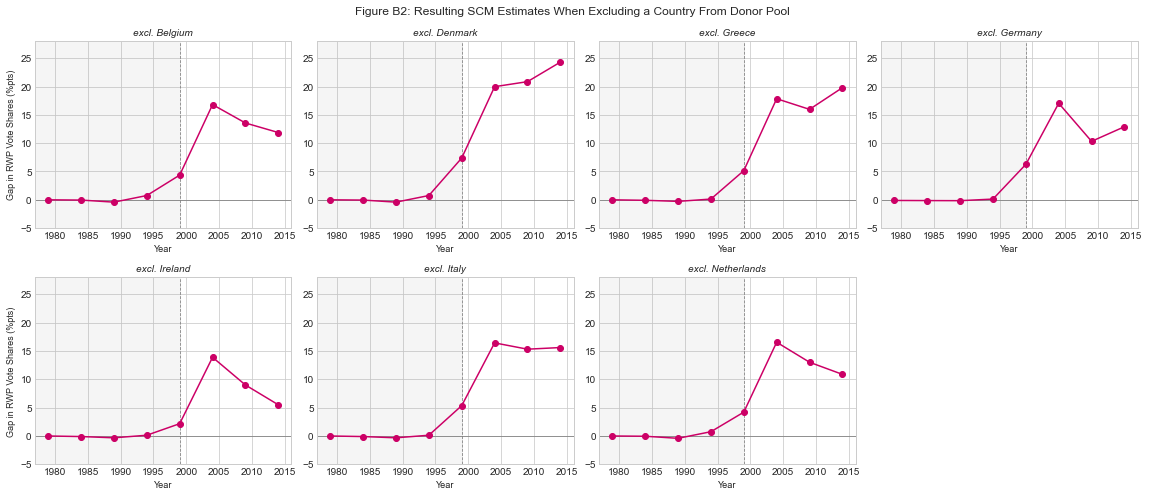

In [23]:
# Leave-one-out plot
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for i, res in enumerate(loo_results):
    ax = axes[i]
    
    ax.axhline(0, color='gray', lw=0.8)
    ax.axvline(1999, color='gray', lw=0.8, ls='--')
    ax.axvspan(1977, 1999, alpha=0.08, color='gray')
    ax.plot(all_years, res['gaps'], 'o-', color='#CC0066', lw=1.5, ms=6)
    ax.set_title(f"excl. {res['excluded']}", fontsize=10, style='italic')
    ax.set_ylim(-5, 28)
    ax.set_xlim(1977, 2016)
    ax.set_xlabel('Year', fontsize=9)
    if i == 0 or i == 4:
        ax.set_ylabel('Gap in RWP Vote Shares (%pts)', fontsize=9)

# Hide empty subplot
axes[7].axis('off')

plt.suptitle('Figure B2: Resulting SCM Estimates When Excluding a Country From Donor Pool', size=12)
plt.tight_layout()
plt.savefig('FigureB2_LOO_Analysis.pdf')
plt.show()

**Interpretation:**

This leave-one-out sensitivity analysis tests the influence of individual donor countries on the suitability of the estimand, meaning it studies the impact of removing a country from the synthetic control donor pool. This is done because removing a country leads to different w-weights (donor/country weights) as well as different v-weights (weights on covariates). This could mean that the approximation of the synthetic UK case to the observed UK in the pre-reform period might vary considerably. While there certainly is some variation visible in the closeness of the approximation, the overall core pattern remains very similar to the main analysis with all donor countries, confirming the general pattern of the main results. 

In short: All panels of Figure B2 show a close or very close match between the treated unit (observed UK) and the respective synthetic counterpart in the pre-reform period.

# 2. SCM: In-Time Placebo

## Version 1: Pysyncon Version

In [24]:
# build dataprep object

## preparation of variables
treatment_time_plac = 1989
pre_years_plac = [1979, 1984]
post_years_plac = [1989, 1994]
years_plac = pre_years_plac + post_years_plac

treated_unit = 'United Kingdom'
donor_units = ['Belgium', 'Denmark', 'Greece', 'Germany', 'Ireland', 'Italy', 'Netherlands']

predictors = ['unempIP', 'opencIP', 'S_uegenIP', 'E_eubadIP', 'E_NatDem_satisfiedIP', 'ch_imp_fns', 'rightgovIP', 'eu_pos_meanIP', 'migr_inflIP']
special_predictors = [
    ("migr_inflIP", [1984],'mean'),
    ("rr_votes", [1984], 'mean')
]

## dataprep object
dataprep_placebo = Dataprep(
    foo=df_synth,
    predictors=predictors,
    predictors_op='mean',
    time_predictors_prior=pre_years_plac,
    special_predictors=special_predictors,
    dependent='rr_votes',
    unit_variable='country',
    time_variable='ep_election',
    treatment_identifier=treated_unit,
    controls_identifier=donor_units,
    time_optimize_ssr=pre_years_plac
)

print(dataprep_placebo)

Dataprep
Treated unit: United Kingdom
Dependent variable: rr_votes
Control units: Belgium, Denmark, Greece, Germany, Ireland, Italy, Netherlands
Time range in data: 1979.0 - 2014.0
Time range for loss minimization: [1979, 1984]
Time range for predictors: [1979, 1984]
Predictors: unempIP, opencIP, S_uegenIP, E_eubadIP, E_NatDem_satisfiedIP, ch_imp_fns, rightgovIP, eu_pos_meanIP, migr_inflIP
Special predictors:
    `migr_inflIP` over `[1984]` using `mean`
    `rr_votes` over `[1984]` using `mean`



In [25]:
# fit synthetic control
synth_1989 = Synth()
synth_1989.fit(dataprep=dataprep_placebo, optim_method='COBYLA', optim_initial='equal')

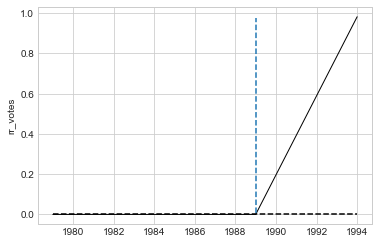

In [26]:
# basic plots (general vs. pointwise)
synth_1989.gaps_plot(time_period=years_plac, treatment_time=1989)

In [27]:
# country weights
weights = synth_1989.weights()
print(f'Country Weights:\n{weights}')

print(f'\nSorted Weights:\n{weights[weights > 0.01].sort_values(ascending=False)}')

print('\nComparing to the Paper: Netherlands (0.753), Ireland (0.229), Belgium (0.018)')

Country Weights:
Belgium        0.000
Denmark        0.673
Greece         0.002
Germany        0.000
Ireland        0.324
Italy          0.000
Netherlands    0.000
Name: weights, dtype: float64

Sorted Weights:
Denmark    0.673
Ireland    0.324
Name: weights, dtype: float64

Comparing to the Paper: Netherlands (0.753), Ireland (0.229), Belgium (0.018)


In [28]:
# predictor weights / comparison
print('Predictor Weights and Balance:')
synth_1989.summary()

Predictor Weights and Balance:


,V,treated,synthetic,sample mean
unempIP,0.020,7.750,7.998,7.329
opencIP,0.020,0.535,0.793,0.735
S_uegenIP,0.015,10.650,9.921,9.236
E_eubadIP,0.242,0.364,0.229,0.109
E_NatDem_satisfiedIP,0.319,0.559,0.629,0.540
ch_imp_fns,0.271,0.321,0.323,0.295
rightgovIP,0.030,0.500,0.500,0.500
eu_pos_meanIP,0.039,4.858,5.431,5.950
migr_inflIP,0.011,186000.000,21833.626,117417.629
special.1.migr_inflIP,0.013,186000.000,21833.626,117417.629


In [29]:
# ATT (post-treatment) and Error Terms
print('MSPE (Mean Squared Approximation Error) Post Treatment:', round(synth_1989.mspe(post_years), 4))
timeplac_att_dict = synth_1989.att(time_period=post_years_plac)
timeplac_att = timeplac_att_dict['att']
timeplac_se = timeplac_att_dict['se']
print(f'In-Time Placebo SCM ATT: {(round(timeplac_att, 4))} (se: {round(timeplac_se, 4)})')

print(f'\nComparison to Main SCM Analysis: ATT = {round(scm_att, 4)} (%pts)')

MSPE (Mean Squared Approximation Error) Post Treatment: 0.0
In-Time Placebo SCM ATT: 0.4913 (se: 0.4913)

Comparison to Main SCM Analysis: ATT = 12.7039 (%pts)


In [30]:
## utilizing helper functions for placebo gaps per year and better styled plots
att_1989 = synth_1989.att(time_period=post_years_plac)
gaps_1989 = get_gaps(synth_1989, years_plac)

print(f'Average in-time placebo effect: {att_1989['att']:.4f}')
print(f'  Standard error: {att_1989['se']:.4f}')

df_gaps_1989 = pd.DataFrame({
    'Year': years_plac,
    'Gap in RWP Vote Shares': gaps_1989,
    'Period': ['pre' if year < 1989 else 'post' for year in years_plac]
})

print('\nGap in RWP Votes Per Year:')
df_gaps_1989.round(4).head(4)

Average in-time placebo effect: 0.4913
  Standard error: 0.4913

Gap in RWP Votes Per Year:


,Year,Gap in RWP Vote Shares,Period
0,1979,0.0000,pre
1,1984,0.0000,pre
2,1989,0.0000,post
3,1994,0.9825,post


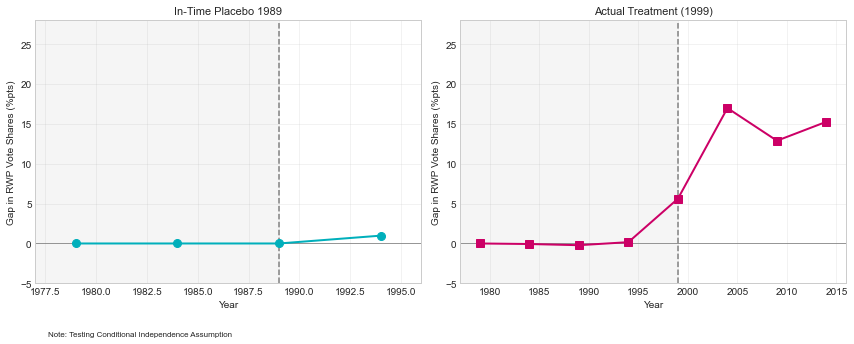

In [31]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Panel A: Time placebo
ax1 = axes[0]
ax1.axhline(0, color='gray', lw=0.8)
ax1.axvline(1989, color='gray', lw=1.5, ls='--')
ax1.axvspan(1977, 1989, alpha=0.08, color='gray')
ax1.plot(years_plac, gaps_1989, 'o-', color='#00AFBB', lw=2, ms=8)
ax1.set_xlim(1977, 1996)
ax1.set_ylim(-5, 28)
ax1.set_title('In-Time Placebo 1989', fontsize=11)
ax1.set_xlabel('Year')
ax1.set_ylabel('Gap in RWP Vote Shares (%pts)')
ax1.grid(alpha=0.3)

# Panel B: Actual treatment
ax2 = axes[1]
ax2.axhline(0, color='gray', lw=0.8)
ax2.axvline(1999, color='gray', lw=1.5, ls='--')
ax2.axvspan(1977, 1999, alpha=0.08, color='gray')
ax2.plot(all_years, gaps, 's-', color='#CC0066', lw=2, ms=8)
ax2.set_xlim(1977, 2016)
ax2.set_ylim(-5, 28)
ax2.set_title('Actual Treatment (1999)', fontsize=11)
ax2.set_xlabel('Year')
ax2.set_ylabel('Gap in RWP Vote Shares (%pts)')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.figtext(0.06, -0.05, 'Note: Testing Conditional Independence Assumption', size=8)
plt.savefig('Figure3_TimePlacebo.pdf')
plt.show()

**Interpretation:**

The in-time placebo tests the **identification assumptions** of SCM which is conditional independence / ignorability (this implies parallel trends, but is stronger). This assumption is violated if the observed UK and its synthetic counterpart diverge from each other in the gap before the true treatment period but after the placebo treatment. If this is the case, it is not possible to make valid, unbiased causal claims because it would instead mean that the result estimated in the main analysis might not stem from the actual treatment but be caused, for example, by noisy data, violations of identification assumption, model misspecifications or omitted variable bias.

From this in-time placebo test we can see clearly that there is a very **small gap in 1994**, otherwise the treated and synthetic control unit would follow identical trajectories and the gap would be 0. Though, this gap can be traced back to the increase in RWP votes in the observed UK in 1994. As stated before, this might challenge the CIA, though the authors account for this general upward trend in RWP vote shares by including a **lagged outcome** variable of RWP vote shares in 1994 in the construction of the v-weights as a covariate. By doing this, they control for this scenario, thereby making their estimate more conservative and preserving the validity of the SCM approach.

That there is still a slight gap between the UK and its synthetic counterpart might be reason for concern or at least a more detailed analysis, though as the in-time placebo ATT (0.4913 percentage points) is very close to zero (se = 0.4913; MSPE = 0.0) and relatively very small compared to the ATT estimates in the main analysis, I would say that the in-time placebo still holds and strengthens the validity and robustness of the results.